In [225]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [380]:
import unittest
from textwrap import dedent
import sys

import networkx as nx
import matplotlib.pyplot as plt

from klara.core.cfg import Cfg
from klara.core.tree_rewriter import AstBuilder
from klara.core.use_def_chain import DefUseLinker, link_stmts_to_def

from cascade.frontend.dataflow_analysis.group_dataflow_nodes import GroupDataflowNodes
from cascade.frontend.dataflow_analysis.edge_placement import EdgePlacement
from cascade.frontend.dataflow_analysis.class_list import ClassList
from cascade.frontend.dataflow_analysis.class_list_builder import ClassListBuilder
from cascade.frontend.dataflow_analysis.class_wrapper import ClassWrapper
from cascade.frontend.util import setup_cfg, plot_graph_with_color, plot_dataflow_graph
from cascade.frontend.cfg import ControlFlowGraph, DataflowGraph

# Dataflow Example

In [381]:
example = dedent("""\
                    class User: 
                        def checkout(self, discount: Discount, item_1: Item, item_2: Item):
                            bill = self.get_bill()
                            discount = discount.get_discount()
                            price_1 = item_1.price(discount)
                            price_2 = item_2.price(discount)
                            bill = bill + price_1
                            bill = bill + price_2
                            return bill
                    
                    class Item:
                        pass
                 
                    class Discount:
                        pass
                    """)

In [382]:
example = dedent(example)
cfg = setup_cfg(example)
class_list: ClassList = ClassListBuilder.build(cfg)
entity_1: ClassWrapper = class_list.get_class_by_name('User')
dataflow_graph: ControlFlowGraph = entity_1.methods['checkout']
G = dataflow_graph.graph
grouper: GroupDataflowNodes = GroupDataflowNodes(G)
groups =  grouper.group_nodes()
f1 = plt.figure(1)
edge_placement: EdgePlacement = EdgePlacement(G, groups)
H = edge_placement.create_dataflow_graph()

<Figure size 640x480 with 0 Axes>

In [383]:

class_list: ClassList = ClassListBuilder.build(cfg)
entity_1: ClassWrapper = class_list.get_class_by_name('User')
dataflow_graph: ControlFlowGraph = entity_1.methods['checkout']
G = dataflow_graph.graph
grouper: GroupDataflowNodes = GroupDataflowNodes(G)
groups =  grouper.group_nodes()
f1 = plt.figure(1)
edge_placement: EdgePlacement = EdgePlacement(G, groups)
H = edge_placement.create_dataflow_graph()

<Figure size 640x480 with 0 Axes>

## Statement level data-dependency graph

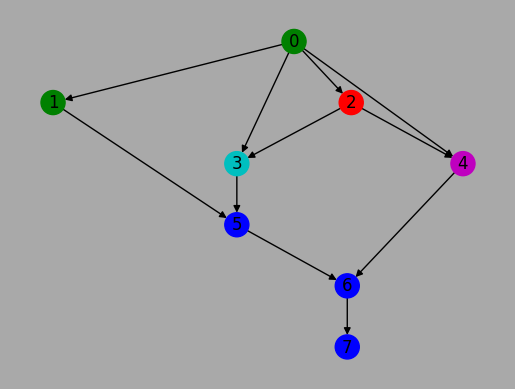

In [384]:
plot_graph_with_color(G)

## Dataflow graph
- Group statements together and remove redundant edges

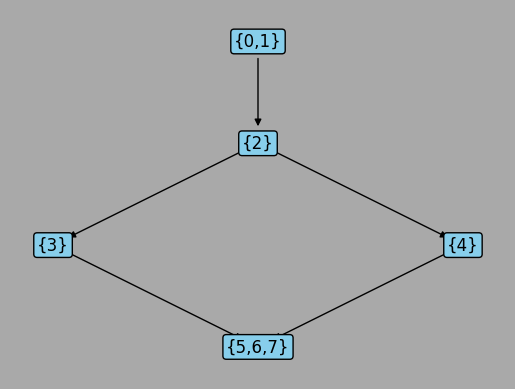

In [385]:
plot_dataflow_graph(H)

## Statement groups

In [386]:
print('Block groups of H')
for block in H.nodes:
    print(f'\n block num {block.block_num}')
    for statement in block.statement_list:
        print(statement.block)

Block groups of H

 block num 0
Function checkout in scope Class "User" in scope Module
Assign: (bill_0,) = Call: self_0.get_bill(())

 block num 1
Assign: (discount_1,) = Call: discount_0.get_discount(())

 block num 2
Assign: (price_1_0,) = Call: item_1_0.price((discount_1,))

 block num 3
Assign: (price_2_0,) = Call: item_2_0.price((discount_1,))

 block num 4
Assign: (bill_1,) = BinOp: bill_0 + price_1_0
Assign: (bill_2,) = BinOp: bill_1 + price_2_0


## Create split functions from statement groups

### Reveal color

In [387]:
for block in H.nodes:
    block.reveal_color()
    print(f'block: {block.block_num} has color: {block.color}')

block: 0 has color: 1
block: 1 has color: 2
block: 2 has color: 3
block: 3 has color: 4
block: 4 has color: 0


All nodes are colored, therefore we must resolve which entities represent which colors.

In [388]:
block_level_dataflow_graph = DataflowGraph(H, dataflow_graph.color_type_map, dataflow_graph.method_name)
print(block_level_dataflow_graph.color_type_map)

{2: 'Discount', 3: 'Item', 4: 'Item', 1: 'User'}


### In variables per block.

In [ ]:
from textwrap import indent
from cascade.frontend.generator.generate_split_functions import GenerateSplitFunctions
from cascade.frontend.cfg import Block

compiled_functions, df = GenerateSplittFunctions.generate_split_function_string(block_level_dataflow_graph)

In [390]:
for v in df.nodes.values():
    print(v)

OpNode(id=264, cls='User', method_type=InvokeMethod(method_name='compiled_method_0'))
OpNode(id=265, cls='Discount', method_type=InvokeMethod(method_name='compiled_method_1'))
OpNode(id=266, cls='Item', method_type=InvokeMethod(method_name='compiled_method_2'))
OpNode(id=267, cls='Item', method_type=InvokeMethod(method_name='compiled_method_3'))
OpNode(id=268, cls='StatelessEntity', method_type=InvokeMethod(method_name='compiled_method_4'))


In [391]:


for node in block_level_dataflow_graph.get_nodes():
    node: Block
    print(f'block {node.block_num} in vars: {node.in_vars}')



block 0 in vars: {'item_2_0', 'discount_0', 'item_1_0'}
block 1 in vars: set()
block 2 in vars: {'discount_1'}
block 3 in vars: {'discount_1'}
block 4 in vars: {'price_1_0', 'bill_0', 'price_2_0'}


In [392]:
print(compiled_functions)

def user_compiled_method_0(variable_map: dict[str, Any], state: User, key_stack: list[str]): 
	item_2_0 = variable_map['item_2_0']
	discount_0 = variable_map['discount_0']
	item_1_0 = variable_map['item_1_0']
	bill_0 = state.get_bill(())
	key_stack.append(discount_0.key))

def discount_compiled_method_1(variable_map: dict[str, Any], state: Discount, key_stack: list[str]): 
	key_stack.pop()
	discount_1 = state.get_discount(())
	key_stack.append([item_1_0.key, item_2_0.key]))

def item_compiled_method_2(variable_map: dict[str, Any], state: Item, key_stack: list[str]): 
	key_stack.pop()
	discount_1 = variable_map['discount_1']
	price_1_0 = state.price((discount_1,))
	key_stack.append(stateless_entity.key))

def item_compiled_method_3(variable_map: dict[str, Any], state: Item, key_stack: list[str]): 
	key_stack.pop()
	discount_1 = variable_map['discount_1']
	price_2_0 = state.price((discount_1,))
	key_stack.append(stateless_entity.key))

def stateless_entity_compiled_method_4(variable_map:

## Helper function

In [424]:
def create_data_flow(example: str):
    example = dedent(example)
    cfg = setup_cfg(example)
    class_list: ClassList = ClassListBuilder.build(cfg)
    entity_1: ClassWrapper = class_list.get_class_by_name('User')
    dataflow_graph: ControlFlowGraph = entity_1.methods['buy_item']
    return dataflow_graph

## Simple program example

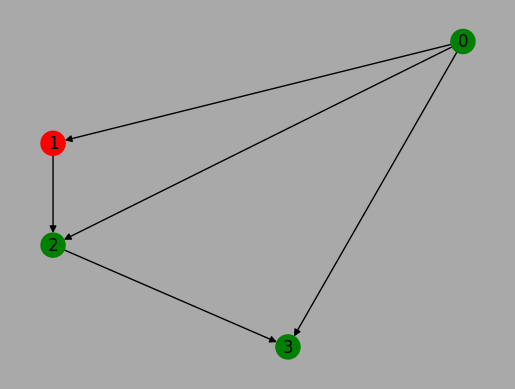

In [454]:
example = """\
                class User: 
                        def buy_item(self, item: Item):
                            item_price = item.item_price() # SSA
                            self.balance = self.balance - item_price
                            return self.balance >= 0

                class Item:
                    pass
                """
dataflow_graph = create_data_flow(example)
G = dataflow_graph.graph
plot_graph_with_color(G)

In [ ]:
split_functions = GenerateSplitFunctions.generate(dataflow_graph)


for i, split in enumerate(split_functions):
    print(f'split: {i}')
    for n in split:
        print(n)
    print()

split: 0
Statement(block_num=0, block=Function buy_item in scope Class "User" in scope Module, targets=[self_0, item_0], values=[self_0, item_0], remote_call=False, attribute_name=None, parent_block=None, color=1)
Statement(block_num=1, block=Assign: (item_price_0,) = Call: item_0.item_price(()), targets=[item_price_0], values=[item_0, item_0.item_price], remote_call=True, attribute_name='item', parent_block=None, color=2)

split: 1
Statement(block_num=2, block=Assign: (self_0.balance_0,) = BinOp: self_0.balance - item_price_0, targets=[self_0.balance_0], values=[self_0, self_0, self_0.balance, item_price_0], remote_call=False, attribute_name='self', parent_block=None, color=1)
Statement(block_num=3, block=<klara.core.node_classes.Return object at 0x13e035950>, targets=[], values=[self_0, self_0.balance_0], remote_call=False, attribute_name='self', parent_block=None, color=1)



## Generated dataflow

### Nodes

In [ ]:
for v in df.nodes.values():
    print(v)

OpNode(id=271, cls='User', method_type=InvokeMethod(method_name='compiled_method_0'))
OpNode(id=272, cls='Item', method_type=InvokeMethod(method_name='compiled_method_1'))


### Edges

In [418]:
print(df.adjacency_list)

{271: [272], 272: [271]}


## Simple example with two items

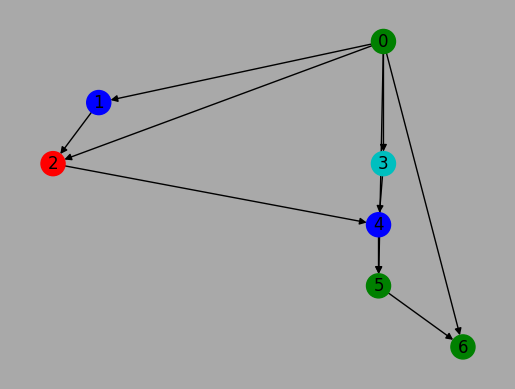

In [453]:
example = """\
                class User: 
                        def buy_item(self, item_1: Item, item_2: Item, discount: int):
                            extra_discount = 0.10 + discount
                            item_price_1 = item_1.item_price_with_discount(extra_discount) # SSA
                            item_price_2 = item_2.item_price()
                            total_price = item_price_1 + item_price_2
                            self.balance = self.balance - total_price
                            return self.balance >= 0

                class Item:
                    pass
                """

keystack.append('item_1_key')

dataflow_graph = create_data_flow(example)

def item_price_with_discount(discount):
    pass

G = dataflow_graph.graph
plot_graph_with_color(G)

In [ ]:
split_functions = GenerateSplitFunctions.generate(dataflow_graph)


for i, split in enumerate(split_functions):
    print(f'split: {i}')
    for n in split:
        print(n)
    print()

split: 0
Statement(block_num=0, block=Function buy_item in scope Class "User" in scope Module, targets=[self_0, item_1_0, item_2_0, discount_0], values=[self_0, item_1_0, item_2_0, discount_0], remote_call=False, attribute_name=None, parent_block=None, color=1)
Statement(block_num=1, block=Assign: (extra_discount_0,) = BinOp: 0.1 + discount_0, targets=[extra_discount_0], values=[discount_0], remote_call=False, attribute_name=None, parent_block=None, color=0)
Statement(block_num=2, block=Assign: (item_price_1_0,) = Call: item_1_0.item_price((extra_discount_0,)), targets=[item_price_1_0], values=[item_1_0, item_1_0.item_price, extra_discount_0], remote_call=True, attribute_name='item_1', parent_block=None, color=2)
Statement(block_num=3, block=Assign: (item_price_2_0,) = Call: item_2_0.item_price(()), targets=[item_price_2_0], values=[item_2_0, item_2_0.item_price], remote_call=True, attribute_name='item_2', parent_block=None, color=3)

split: 1
Statement(block_num=4, block=Assign: (tota